# Fig 2. Paper version

Bar plots for different thresholds/metrics (MEDIAN as BE)


To do
- Update population - DONE
- check whether to do mean/median, consistent in both? - for reporting use delta method to aggregate estimates??
- run with other hist models too!
- Decide on aesthetics / labels etc

For SI:
- make SI figure with normalized slopes for all metrics/thresholds
- some extra bar plots for different metrics? 

see also: attr-hw-imsc2-isimp3b 

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, (statsmodels??)

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4
import matplotlib.patches as mpatches


%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings_ana import *

# import fxns 
from functions_ana import *
from utils_ana import *
from plotscript import *

# import other packages/modules 
sys.path.append(os.path.join(os.environ['VSC_DATA_VO_USER'],'demographics4climate/'))
from population_demographics import * 

In [2]:
start_message()

flags: {'models': 'ISIMIP3b', 'experiment': None, 'metric': 'WBGT28', 'method': None, 'time_method': None, 'shift_sigma': False, 'shift_period': None, 'shift_loglike': None, 'chunk_version': None, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'EC-Earth3', 'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'CNRM-ESM2-1']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
tim

In [3]:
from dask.distributed import Client 
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34651,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:43773,Total threads: 1
Dashboard: http://127.0.0.1:45529/status,Memory: 40.00 GiB
Nanny: tcp://127.0.0.1:43811,


In [4]:
figdir = os.path.join(figdirs, 'fig_sep24')


# 00. Plotting and reporting functions (finalize+move from here)

To do
- do median + IQR in all?
- finalise reporting fxns, check different ways of CI and aggregating/reporting result 

In [5]:

# NEW: plot model median and range - rename fxn

def plot_barplot_n_prop_people_atleastx_modelmean(da, 
                                                  unit, 
                                                  ax, 
                                                  year=2022, 
                                                  proportion=False, 
                                                  x_hot_days = [1,5,10,20,50],
                                                 legend=True,
                                                 errcolor='gray',
                                                 color=None,
                                                 set_xticklabel=True,
                                                 rotation=40,
                                                 ylabel=None):
    # plot range 
    if unit == 1e9:
        unit_str = 'billions'
    elif unit == 1e6:
        unit_str='millions'
    else:
        unit_str = ''

    upper_error = (da.max(dim='model')-da.astype(float).median(dim='model')).values.T /unit
    lower_error = (da.astype(float).median(dim='model')-da.min(dim='model')).values.T /unit
    try:
        concatenated =np.concatenate((lower_error,upper_error), axis=1)
        reshaped = np.reshape(concatenated, (len(da.features), 2, len(da.age_ranges)))
    except:
        concatenated =np.concatenate((lower_error,upper_error))
        reshaped = np.reshape(concatenated, (2, len(da.age_ranges)))

    # plot multi-model mean 
    if color == None:
        (da.astype(float).median(dim='model')/unit).to_pandas().plot.bar(ax=ax,
                                                   yerr=reshaped,
                                                   error_kw=dict(ecolor=errcolor, alpha=1, elinewidth=.8, capsize=1))
    else:
        (da.astype(float).median(dim='model')/unit).to_pandas().plot.bar(ax=ax,
                                                   yerr=reshaped,
                                                         color=color,
                                                   error_kw=dict(ecolor=errcolor, alpha=1, elinewidth=.8, capsize=1))        
    if ylabel is None:
        if proportion:
            ax.set_ylabel(f'Proportion of age group (%)')

        else:
            ax.set_ylabel(f'Number of people ({unit_str})')
    else:
        ax.set_ylabel(ylabel)

    ax.set_xlabel(' ')
    
    if set_xticklabel:
        step_ages = int(da.age_ranges[1] -da.age_ranges[0] - 1)
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+step_ages}' for x in da.age_ranges.values],  
                      rotation=rotation, rotation_mode='anchor',ha='right') #'horizontal'
    else:
        ax.set_xticklabels('')
    
    if legend==True:
        ax.legend(labels = [f'at least {x}' for x in x_hot_days])

In [6]:
def plot_percapitadays_median_iqr(da, 
                                  feature, 
                                  ax,
                                  set_xticklabel=True,
                                  ylabel='Per capita attributable \nhot-humid days per year',
                                 rotation=40):
    
    df_plot =  da.sel(features=feature).to_pandas()
    
    medianprops = dict(color='k',linewidth=2)
    whiskerprops = dict(color='none')
    capprops = dict(color='none')

    plot = ax.boxplot(df_plot,  
                      whiskerprops=whiskerprops, 
                      capprops=capprops, 
                      medianprops=medianprops,
                      patch_artist=True,
                      showfliers=False) #boxprops=boxprops,

    col='cadetblue'
    for patch in plot['boxes']:
            patch.set_facecolor(col)
            patch.set_edgecolor(col)

    if set_xticklabel:
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.columns], 
                      rotation=rotation,rotation_mode='anchor',ha='right');
    else:
        ax.set_xticklabels('')
    plt.ylabel(ylabel)


In [7]:

def reporting_summary(df, args, axis=1):
    #summary = {arg: getattr(df, arg)(axis=axis) for arg in args}
    summary = {}
        # Iterate over each requested summary statistic
    for arg in args:
        if arg == "q1":
            summary["Q1"] = df.quantile(0.25, axis=axis)
        elif arg == "q3":
            summary["Q3"] = df.quantile(0.75, axis=axis)
        else:
            # Handle standard functions like "min", "max", "median"
            summary[arg] = getattr(df, arg)(axis=axis)
    
    # Concatenate results along columns
    df_summary = pd.concat(summary, axis=1)
    
    return df_summary.astype('float64').round(2)
    

## 0. Population preprocessing


In [8]:
gs_population_global = population_demographics_gridscale_global(startyear=2023,
                                                                endyear=2023,
                                                                ssp=2,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


## 1. WBGT28 Reanalysis 

loc only models



In [9]:
flags['models']='ISIMIP3a'
dirname = 'output_shift-fit' 

da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit/forster2024/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_loglike_1901_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    
    da_params = xr.concat(da_list, dim="dataset")
    

In [10]:
df_gmst_obs_annual = pd.read_csv(os.path.join('../../data/gmst/gmst-obs/forster2024/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
gmst_smo = pd.DataFrame(apply_lowess(df_gmst_obs_annual, df_gmst_obs_annual.index, ntime=4))
#gmst_smo

In [11]:
threshold = 28

from scipy.stats import norm

da_nAHD_obs, da_nAHD_mo, da_p0, da_p1 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=1.3)

In [12]:
da_nAHD = da_nAHD_obs.rename({'dataset':'model'})

da_n_people_ndays_obs, da_prop_people_ndays_obs = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

## 2. Climate models 

In [13]:
dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 


In [14]:
da_nAHD = da_nAHD_models

da_n_people_ndays_models, da_prop_people_ndays_models = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

## 3. Plots

### v1

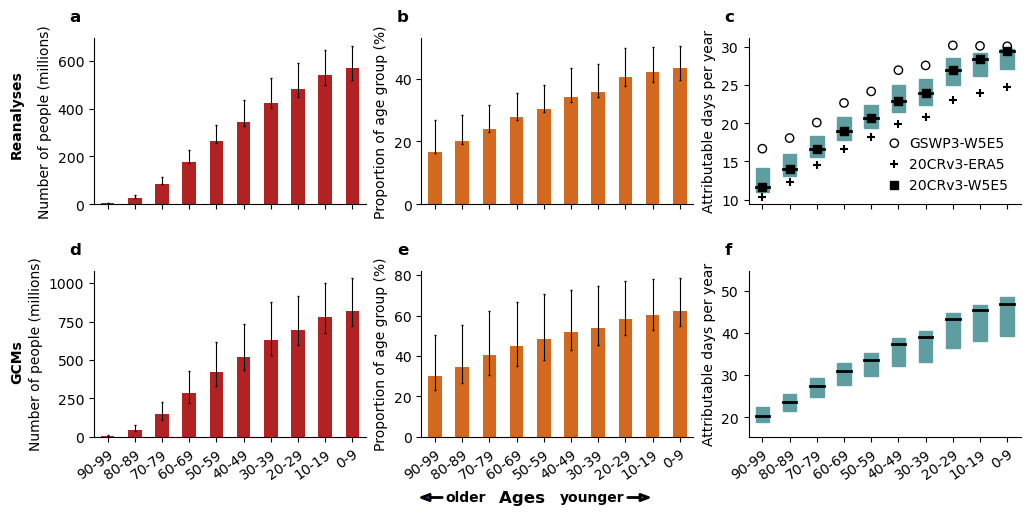

In [15]:
# settings
xpos=-.09
ypos=1.05


fig,axes=plt.subplots(2,3,figsize=(10,5),layout='constrained',facecolor='none') # 10,5

axes=axes.flatten()


ax=axes[0]
ax.set_title('a',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays_obs.sel(features='n_atleast_20'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              set_xticklabel=False,
                                              #ylabel='People (10$^6$)'
                                             )


ax=axes[1]
ax.set_title('b',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays_obs.sel(features='prop_atleast_20') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              set_xticklabel=False,
                                              ylabel='Proportion of age group (%)')

ax=axes[2]
ax.set_title('c',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                             ylabel='Attributable days per year')

# Overlay points 
df_plot = da_nAHD_percapita_peopledays_10y_obs.sel(features='per_capita_days').to_pandas()

for i in range(df_plot.shape[1]):  
    l1 = ax.scatter([i + 1], df_plot.iloc[0, i], zorder=3, facecolors='none', edgecolors='k', ) #[".","+","x"]
    l2 = ax.scatter([i + 1], df_plot.iloc[1, i], zorder=3, facecolors='k',marker="+",) #[".","+","x"]
    l3 = ax.scatter([i + 1], df_plot.iloc[2, i], zorder=3, facecolors='k', edgecolors='k',marker="s") # marker="x",) #[".","+","x"]

ax.legend([l1, l2, l3], [df_plot.index[0], df_plot.index[1], df_plot.index[2]], frameon=False, handletextpad=0.08,) # fontsize=9 keep defaultfontsize if size 10,5

ax.set_ylabel('Attributable days per year')


ax=axes[3]
ax.set_title('d',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays_models.sel(features='n_atleast_20'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              set_xticklabel=True,
                                              rotation=35,
                                             )

ax=axes[4]
ax.set_title('e',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays_models.sel(features='prop_atleast_20') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              rotation=35,
                                             ylabel='Proportion of age group (%)')

ax=axes[5]
ax.set_title('f',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=35,
                             ylabel='Attributable days per year'
                             )




fig.text(-.015,.7, 'Reanalyses', ha='left',rotation=90, fontweight='bold');
fig.text(-.015,.25, 'GCMs', ha='left',rotation=90, fontweight='bold');
fig.supxlabel('Ages ', y=0,fontweight='bold'); #c='0.5',size=14


# arrow annotation older/younger 
arr = mpatches.FancyArrowPatch((0.6, 0.015), (0.63, 0.015),  # Coordinates in figure fraction
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )
fig.patches.append(arr)
fig.text(0.535, 0.015, "younger", ha='left', va='center', fontweight='bold')
arr = mpatches.FancyArrowPatch((.42, 0.015), (.39, 0.015),  
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )  
fig.patches.append(arr)
fig.text(0.42, 0.015, "older", ha='left', va='center',fontweight='bold')

for ax in axes:
    ax.invert_xaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


#plt.savefig(os.path.join(figdir,'fig2-median.png'),dpi=300,bbox_inches='tight',transparent=True)
#plt.savefig(os.path.join(figdir,'fig2-median.pdf'),dpi=300,bbox_inches='tight',transparent=True)

### v2

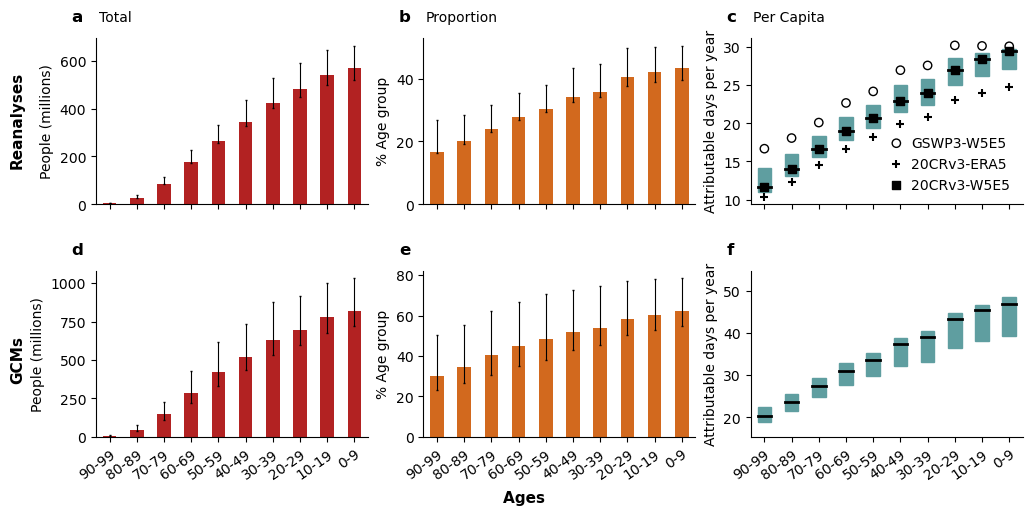

In [32]:
# settings
xpos=-.09
ypos=1.05


fig,axes=plt.subplots(2,3,figsize=(10,5),layout='constrained',facecolor='none') # 10,5

axes=axes.flatten()

ylabels = ['Millions of people', '% Age group', 'Days']
ylabels = ['People (millions)', '% Age group', 'Attributable days per year']

titles = ['Total', 'Proportion', 'Per Capita']


ax=axes[0]
ax.set_title('a',loc='left',fontweight='bold',x=xpos,y=ypos)
ax.text(x=xpos+.1,y=ypos+0.05,s=titles[0],transform=ax.transAxes)
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays_obs.sel(features='n_atleast_20'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              set_xticklabel=False,
                                              ylabel=ylabels[0]
                                             )


ax=axes[1]
ax.set_title('b',loc='left',fontweight='bold',x=xpos,y=ypos)
ax.text(x=xpos+.1,y=ypos+0.05,s=titles[1],transform=ax.transAxes)

plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays_obs.sel(features='prop_atleast_20') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              set_xticklabel=False,
                                              ylabel=ylabels[1]
                                             )

ax=axes[2]
ax.set_title('c',loc='left',fontweight='bold',x=xpos,y=ypos)
ax.text(x=xpos+.1,y=ypos+0.05,s=titles[2],transform=ax.transAxes)

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                             ylabel=ylabels[2])

# Overlay points 
df_plot = da_nAHD_percapita_peopledays_10y_obs.sel(features='per_capita_days').to_pandas()

for i in range(df_plot.shape[1]):  
    l1 = ax.scatter([i + 1], df_plot.iloc[0, i], zorder=3, facecolors='none', edgecolors='k', ) #[".","+","x"]
    l2 = ax.scatter([i + 1], df_plot.iloc[1, i], zorder=3, facecolors='k',marker="+",) #[".","+","x"]
    l3 = ax.scatter([i + 1], df_plot.iloc[2, i], zorder=3, facecolors='k', edgecolors='k',marker="s") # marker="x",) #[".","+","x"]

ax.legend([l1, l2, l3], [df_plot.index[0], df_plot.index[1], df_plot.index[2]], frameon=False, handletextpad=0.08,) # fontsize=9 keep defaultfontsize if size 10,5

ax.set_ylabel(ylabels[2])


ax=axes[3]
ax.set_title('d',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays_models.sel(features='n_atleast_20'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              set_xticklabel=True,
                                              rotation=35,
                                              ylabel=ylabels[0]
                                             )

ax=axes[4]
ax.set_title('e',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays_models.sel(features='prop_atleast_20') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              rotation=35,
                                             ylabel=ylabels[1])

ax=axes[5]
ax.set_title('f',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=35,
                             ylabel=ylabels[2]
                             )




fig.text(-.017,.68, 'Reanalyses', ha='left',rotation=90, fontweight='bold',size=11);
fig.text(-.017,.25, 'GCMs', ha='left',rotation=90, fontweight='bold',size=11);
fig.supxlabel('Ages ', y=0,fontweight='bold',size=11); #c='0.5',size=14

for ax in axes:
    ax.invert_xaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# plt.savefig(os.path.join(figdir,'fig2_v2-median.png'),dpi=300,bbox_inches='tight',transparent=True)
# plt.savefig(os.path.join(figdir,'fig2_v2-median.pdf'),dpi=300,bbox_inches='tight',transparent=True)

## 4. Reporting numbers

### Models

In [17]:
df = da_n_people_ndays_models.sel(features='n_atleast_20').to_pandas().T / 1e6

reporting_summary(df, ['mean', 'min', 'max' , 'median'],axis=1).round(0)

,mean,min,max,median
age_ranges,,,,
0,839.0,718.0,1030.0,818.0
10,801.0,676.0,1000.0,776.0
20,722.0,599.0,917.0,696.0
30,664.0,533.0,880.0,633.0
40,546.0,435.0,732.0,520.0
50,437.0,333.0,618.0,422.0
60,297.0,223.0,425.0,287.0
70,151.0,111.0,225.0,146.0
80,49.0,36.0,75.0,47.0


In [18]:
df = da_prop_people_ndays_models.sel(features='prop_atleast_20').to_pandas().T * 100

reporting_summary(df, ['mean', 'min', 'max',  ],axis=1).round(0)

,mean,min,max
age_ranges,,,
0,64.0,55.0,78.0
10,62.0,53.0,78.0
20,61.0,50.0,77.0
30,56.0,45.0,75.0
40,54.0,43.0,73.0
50,50.0,38.0,71.0
60,46.0,35.0,67.0
70,42.0,31.0,62.0
80,36.0,27.0,55.0


In [19]:
df = da_nAHD_percapita_peopledays_10y_models.sel(features='per_capita_days').to_pandas().T

reporting_summary(df, ['median', 'q1', 'q3', 'min', 'max' ]).round(0)

,median,Q1,Q3,min,max
age_ranges,,,,,
0,47.0,39.0,48.0,36.0,53.0
10,46.0,38.0,47.0,35.0,52.0
20,43.0,37.0,45.0,34.0,51.0
30,39.0,33.0,41.0,32.0,46.0
40,37.0,32.0,39.0,31.0,45.0
50,34.0,30.0,35.0,28.0,41.0
60,31.0,28.0,33.0,26.0,38.0
70,27.0,25.0,29.0,23.0,34.0
80,24.0,21.0,26.0,20.0,30.0


#### 0-9 vs. 60-69

In [20]:
# Multiplication factor n people 0-9 v 60-69 
df = pd.DataFrame( da_n_people_ndays_models.sel(features='n_atleast_20').to_pandas().T.loc[0] / da_n_people_ndays_models.sel(features='n_atleast_20').to_pandas().T.loc[60] ).T

reporting_summary(df, ['mean', 'min', 'max', 'median' ]) 

,mean,min,max,median
0,2.86,2.42,3.21,2.86


In [21]:
# Multiplication factor prop people 0-9 v 60-69 
df = pd.DataFrame( da_prop_people_ndays_models.sel(features='prop_atleast_20').to_pandas().T.loc[0] / da_prop_people_ndays_models.sel(features='prop_atleast_20').to_pandas().T.loc[60] ).T

reporting_summary(df, ['mean', 'min', 'max', 'median' ])

,mean,min,max,median
0,1.39,1.18,1.56,1.39


In [22]:
# Multiplication factor days per capita people 0-9 v 60-69 
df_raw = da_nAHD_percapita_peopledays_10y_models.sel(features='per_capita_days').to_pandas().T
df = pd.DataFrame( df_raw.loc[0] / df_raw.loc[60] ).T

reporting_summary(df, ['mean', 'min', 'max', 'median' ])

,mean,min,max,median
0,1.44,1.31,1.6,1.45


### Reanalysis

In [23]:
df = da_n_people_ndays_obs.sel(features='n_atleast_20').to_pandas().T / 1e6

reporting_summary(df, ['mean', 'min', 'max' , 'median'],axis=1)

,mean,min,max,median
age_ranges,,,,
0,584.69,519.88,662.91,571.27
10,560.26,497.39,643.23,540.16
20,507.09,449.31,590.67,481.30
30,450.40,401.54,527.74,421.91
40,369.78,328.62,436.35,344.38
50,285.41,256.52,333.28,266.41
60,191.20,171.02,225.04,177.53
70,94.28,82.76,113.55,86.52
80,30.55,25.94,38.57,27.15


In [24]:
df = da_prop_people_ndays_obs.sel(features='prop_atleast_20').to_pandas().T * 100

reporting_summary(df, ['mean', 'min', 'max' , 'median'],axis=1).round(0)

,mean,min,max,median
age_ranges,,,,
0,44.0,40.0,50.0,43.0
10,44.0,39.0,50.0,42.0
20,43.0,38.0,50.0,40.0
30,38.0,34.0,45.0,36.0
40,37.0,33.0,43.0,34.0
50,33.0,29.0,38.0,30.0
60,30.0,27.0,35.0,28.0
70,26.0,23.0,31.0,24.0
80,23.0,19.0,29.0,20.0


In [25]:
df = da_nAHD_percapita_peopledays_10y_obs.sel(features='per_capita_days').to_pandas().T

reporting_summary(df, ['median', 'q1', 'q3' , 'min', 'max']).round(0)

,median,Q1,Q3,min,max
age_ranges,,,,,
0,29.0,27.0,30.0,25.0,30.0
10,28.0,26.0,29.0,24.0,30.0
20,27.0,25.0,29.0,23.0,30.0
30,24.0,22.0,26.0,21.0,28.0
40,23.0,21.0,25.0,20.0,27.0
50,21.0,19.0,22.0,18.0,24.0
60,19.0,18.0,21.0,17.0,23.0
70,17.0,16.0,18.0,15.0,20.0
80,14.0,13.0,16.0,12.0,18.0


#### 0-6 vs 60-69

In [26]:
# Multiplication factor n people 0-9 v 60-69 
df = pd.DataFrame( da_n_people_ndays_obs.sel(features='n_atleast_20').to_pandas().T.loc[0] / da_n_people_ndays_obs.sel(features='n_atleast_20').to_pandas().T.loc[60] ).T

reporting_summary(df, ['mean', 'min', 'max', 'median' ])

,mean,min,max,median
0,3.07,2.95,3.22,3.04


In [27]:
# Multiplication factor n people 0-9 v 60-69 
df = pd.DataFrame( da_prop_people_ndays_obs.sel(features='prop_atleast_20').to_pandas().T.loc[0] / da_prop_people_ndays_obs.sel(features='prop_atleast_20').to_pandas().T.loc[60] ).T

reporting_summary(df, ['mean', 'min', 'max', 'median'  ])

,mean,min,max,median
0,1.49,1.43,1.56,1.48


In [28]:
# Multiplication factor n people 0-9 v 60-69 
df_raw = da_nAHD_percapita_peopledays_10y_obs.sel(features='per_capita_days').to_pandas().T
df = pd.DataFrame( df_raw.loc[0] / df_raw.loc[60] ).T

reporting_summary(df, ['mean', 'min', 'max', 'median'  ])

,mean,min,max,median
0,1.46,1.33,1.55,1.49


#### 0-9 vs. 80-89

In [29]:
# Multiplication factor n people 0-9 v 60-69 
df = pd.DataFrame( da_n_people_ndays_obs.sel(features='n_atleast_20').to_pandas().T.loc[0] / da_n_people_ndays_obs.sel(features='n_atleast_20').to_pandas().T.loc[80] ).T

reporting_summary(df, ['mean', 'min', 'max', 'median' ])

,mean,min,max,median
0,19.42,17.19,21.04,20.04


In [30]:
# Multiplication factor prop people 0-9 v 60-69 
df = pd.DataFrame( da_prop_people_ndays_obs.sel(features='prop_atleast_20').to_pandas().T.loc[0] / da_prop_people_ndays_obs.sel(features='prop_atleast_20').to_pandas().T.loc[80] ).T

reporting_summary(df, ['mean', 'min', 'max', 'median'  ])

,mean,min,max,median
0,2.0,1.77,2.16,2.06


In [31]:
# Multiplication factor pcapdays people 0-9 v 60-69 
df_raw = da_nAHD_percapita_peopledays_10y_obs.sel(features='per_capita_days').to_pandas().T
df = pd.DataFrame( df_raw.loc[0] / df_raw.loc[80] ).T

reporting_summary(df, ['mean', 'min', 'max', 'median'  ])

,mean,min,max,median
0,1.93,1.67,2.11,2.02
